# Predicting Lending Club Loan Statuses

Author: Chitwan Kaudan

In [29]:
import os
import datetime
import pandas as pd
import numpy as np

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

## Abstract

Lenders know that not everyone they loan money to will pay them back in full. That's why before you can recieve a loan banks look at your credit score, your credit history, outstanding balances, income, etc. to determine what type of risk you pose to the bank. In the past, we've seen that when these thresholds are relaxed too much, defaults skyrocket sometimes with disastrous implications on the economy (i.e. housing market crash & '08 crisis). So we know these thresholds banks impose help weed out bad risk. 

But what about loans that pass all the thresholds? Of these loans, can we predict which loans will default and which won't? Is it true that lenders closer to the threshold cut offs tend default more often? With what accuracy can we make these predictions? Which metrics are the most important our predictions?


## Exploratory Data Analysis

### Introducing LC Dataset 
We'll be using Lending Club's public loan [datasets](https://www.lendingclub.com/info/download-data.action) in our analysis. As of 1/7/18, LC has loan data availible from 2007 to Q3 2017 and posts new data in increments of quarters. Each row represents a loan issued within the time period listed in the file name. All loans are either 3 year or 5 year loans. Each loan has 60+ variables- brief explainations of all variables can be found in a supplementary csv on the same page. Note that not all variables are publically availible. Things like fico score nad other variables require a LC membership. Since I want this project to be reproducible by anyone, our analysis will be limited to the data that is 100% publically availible. 

### Minimum Tracking Quarters & Variable Selection

Although LC provide 60+ variables for each loan, we don't want to use all variables for the following 3 reasons: 

1. **Sparse data**: many variables are extremely sparse. Not all variables apply to each loan or certain data is be omited by LC. Whatever the reason, sparse data can bias our analysis even with datasets are large as ours. You can read Dr. Greenland's [paper](http://www.bmj.com/content/352/bmj.i1981) if you'd like to learn more about sparse data biases on multivariable analysis. 
2. **Multicollinearity**: many variables within the dataset are obviously collinear (i.e. grade and subgrade). Collinearilty will surely inflate the standard errors of our variables and may underestimate the significance of our independent variables in our regression. 
3. **Lack of hueristic logic**: our goal with this project is to create a model that can use data a borrower provides upon recieveing the loan to predict whether he will pay it off. Many variables such as current balance on the loan and # of late payments are not variables that would be availible upon loan issuance. Our job isn't to achieve the best possible accuracy rate- our job is to achieve the best accruacy within our framework of our original scientific question. 

For the above reasons, we'll only selecting certain variables to be a part of our analysis. You of course may disagree with the selections I've made. Please feel free to modify the code to test any theories you may have. I understand my analysis is limited, that's why I've made the project easy to reproduce and modfiy!

I've selected *loan_status* to be my target or dependent variable. For all dataset except 2007-2011, *loan_status* is a categorical variable with the following levels. 

In [6]:
assembled = pd.read_pickle("processed/assembled.pkl")
assembled['loan_status'].value_counts()

Fully Paid            520559
Current               490420
Charged Off           135460
Late (31-120 days)     16685
In Grace Period         9039
Late (16-30 days)       3550
Default                   42
Name: loan_status, dtype: int64

So a loan can either fully paid off or current which means all payments are up to date. Otherwise the loan can be in grace period which is typically a 15 day period after the payment due date in which you can submit your payment with no late fee charges. After the grace period is over, that the loan will become Late (16-30 days), Late (31-120 days) and eventually Defaulted if no payment is made. After an additional 30 days, the loan will become Charged Off meaning the lender no longer expects the borrower to make any more payments towards the loan.

My first thought was use a basic classification tree (analogously one-way ANOVA) to "classify" these loans into the 5 loan status categories. Immediately 2 problems arose. First, if I fed the algorithim all the variables it would simply decide to split on variables with the highest predictive power (i.e. current balance) disregarding our hueristic mission with this analysis (see point 3 above). I could preselect variables that meet our explanatory criteria and only run the greedy algo on this subset. The second issue is a bit tougher to solve. Loan categories proportions did not remain steady over time. There was virtually no current loans in the older datasets and whereas the newer datasetst (circa 2016) had nearly 90% current loans. Hueristially, this makes perfect sense. It's a lot easier to stay current on your payments if your loan is a only a couple months old. This natural phenomenon is a problem for us because if weare trying build a model using old loan data and predict status for new loan data, our predictions would be very off. 

So maybe the porportion of current loans doesn't remain steady across datasets, but the proportion of loans "in good standing" (fully paid or current) do. The thought behind this is that ***most*** loans simply go from current to full paid off as time goes on. This of course is not true 100% of the time- again it's a lot easier to be "in good standing" during the first few months of your loan than it is to be 2-3 years into it. So we will need to find impose some "minimum tracked quarters" and throw out loans that are too young. Let's take a look at the "in good standing" proportions across the availible datasets to determine this threshold.

In [54]:
rawdat = ['12-13', '14', '15', '16Q1', '16Q2', '16Q3', '16Q4', '17Q1', '17Q2']

In [55]:
good_standing = []
for date in rawdat:
    data = pd.read_pickle('data/'+date+'raw.pkl')
    good_perc = ((data.loan_status.value_counts())["Fully Paid"] 
                 + (data.loan_status.value_counts())["Current"]) / data.loan_status.count()
    good_standing.append(good_perc)

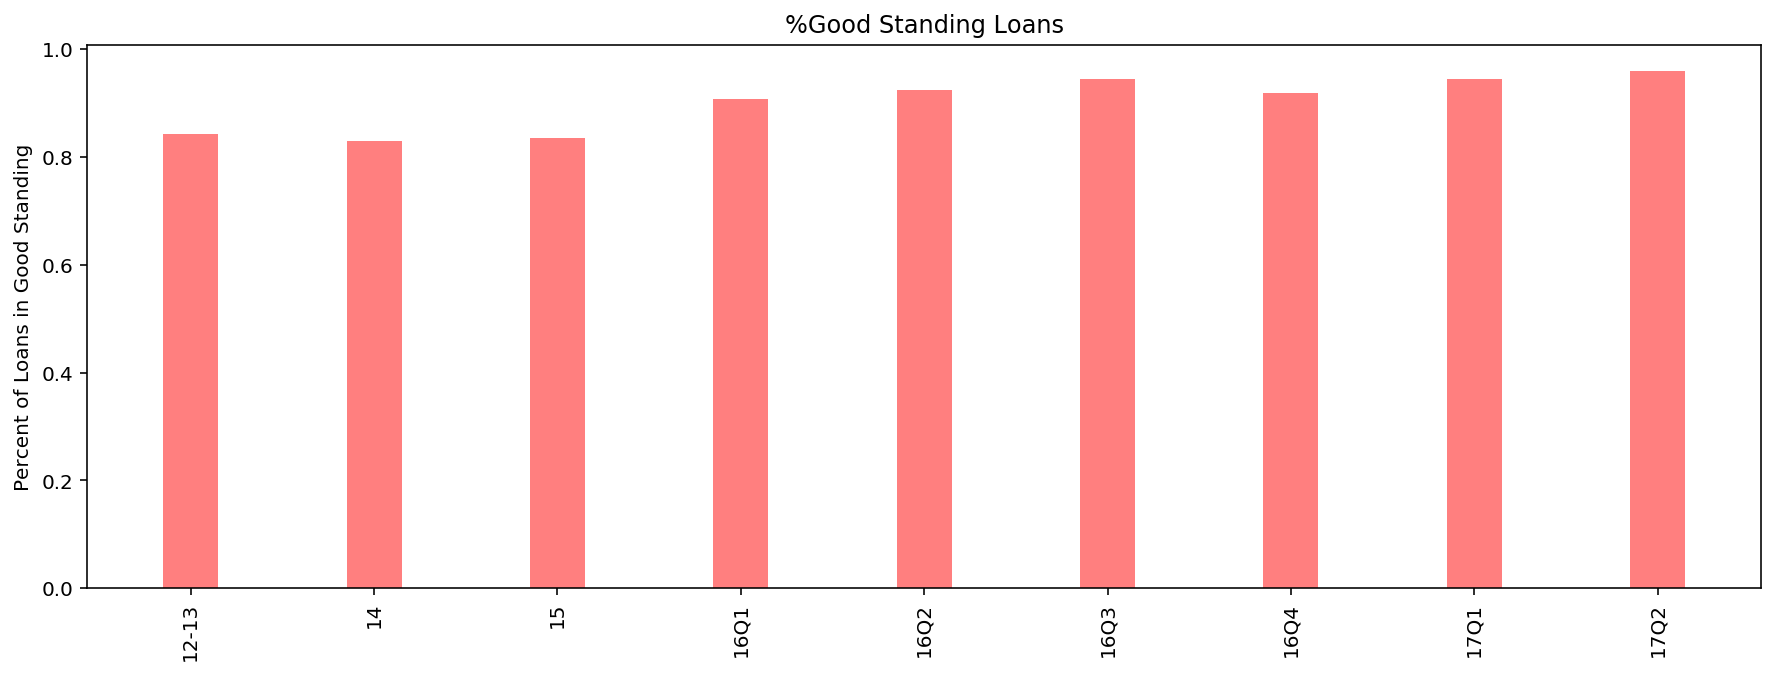

In [57]:
# Setting the positions and width for the bars
pos = list(range(len(rawdat))) 
width = 0.3

# Plotting the bars
fig, ax = plt.subplots(figsize=(15,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, good_standing, 
        width, alpha=0.5, color='r') 

# Set the y axis label
ax.set_ylabel('Percent of Loans in Good Standing')

# Set the chart's title
ax.set_title('%Good Standing Loans')

# Set the position of the x ticks
ax.set_xticks(pos)
plt.xticks(rotation = 'vertical')

# Set the labels for the x ticks
ax.set_xticklabels(rawdat)

plt.show()

My theory seems to be right. Percent of loans in good standing does seem to remain relatively stable and you can also see the upwards trend as you get younger loans. It doesn't seem obvious where we should make the cut off. In my analysis, I chose 5 minumum tracking quarters, so the cut off for me was Q3 2016. My analysis uses data from 2012-Q3 2016. You can  the minumum trackng quarters in settings.py if you wish.

Having selected the minimum tracking quarters then chose the list of variables I thought would be availible to banks at loan issuance. The variables are the following:

- loan_amnt: loan amount issued
- term: 3 or 5 year loan
- int_rate: interest rate on the loan
- installment: monthly payment owed by the borrower
- sub_grade: LC assigned loan subgrade
- emp_length: how long borrower has been employeed
- home_ownership: whether or not borrower is a homeowner
- annual_inc: annual income of borrower
- verification_status: indicates if income was verified by LC, not verified, or if the income source was verified
- issue_d: date of issuance
- purpose: a category selected by borrower upon loan request
- addr_state: state in which borrower resides
- dti: a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income
- earliest_cr_line: time of borrow's first credit line
- open_acc: # of open account under borrower's name
- pub_rec: # of derogatory public record 
- revol_util: total credit revolving balance
- initial_list_status: the initial listing status of the loan. Possible values are – W, F
- application_type: indicates whether the loan is an individual application or a joint application with two co-borrowers
- tot_cur_bal: total current balance on all accounts
- tot_hi_cred_lim: total high credit/credit limit

Again these are variables I thought would affects the likelihood a loan is paid back. You may disaggree. Please fee free to change the selected variables in assemble.py. (Don't forget to specify dtype right underneath!)


## Results

Essentially, I chose to split the data into 3 folds. Using the above variables in my model, I trained a model of 2 folds of the data and make a prediction on the 3rd fold. I then used cross validation accuracy score, # of false positives, and # of false negatives to evaluate how good of a model I created.

If you'd like you can change the number of folds in settings.py. I found more folds doesn't have much of an impact on model performance. Below are the resutls from my trial:

In [60]:
%cat results.txt

Accuracy Score: 0.6467770212835519
False Negatives: 0.3454641095095289
False Positives: 0.39547903521136035


Overall, my model has an approximately 65% accuracy rate which is not a bad start. Crossvalidation is of course random so these numbers fluctuate with every trial, but I found the accuracy scores remain within a 0.02+/- of the above numbers.

The false positive rate is nearly 40% which quite high. Its possible to improve the model using different variables. Feel free to experiment with different combinations of variables. These were the best accuracy scores I could achieve. 

I believe the non-public LC like fico score and credit score would also be a important variable to improve the model.